# Image Search on Brain MRI Scans

This example demonstrates how to store [brain scan images](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri) as vector embeddings in KDB.AI, then how to search this dataset to instantly retrieve similar images.

Brain tumors are intricate due to variations in size and location, therefore understanding their nature is challenging. Professional neurosurgeons are essential for accurate MRI analysis, but in developing nations, the scarcity of skilled doctors and tumor knowledge results in time-consuming report generation from MRI scans. 

A potential solution lies in automated systems like vector database search, which could help alleviate this issue. Using semantic search, KDB.AI enables users to effectively retrieve the most similar scan images quickly even when the query and database content aren't an exact match, leveraging semantic context. 

## Aim 
In this tutorial, we'll walk through the process of storing images in a vector database, using a pre-trained neural network to generate data structures known as vector embeddings. We will use KDB.AI's vector database offering to find images with similar vector embeddings to an input query image. We will cover the following topics:

- How to create vector embeddings using images
- How to store those embeddings in KDB.AI
- Query KDB.AI's Vector Database to find similar images to the query


## Install Dependencies 

In [ ]:
!pip install tensorflow Pillow matplotlib kdbai_client -q

## 1. Download Data

### Dataset Overview
The dataset that will be used for this example is the [Brain Tumor Classification](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri) images available on Kaggle. The dataset consist of images which are already split into Training and Testing folders.
Each folder has more four subfolders. These subfolders have MRIs corresponding to four different tumor classes: Glioma, Meningioma, Notumor, Pituitary.

### Load Data

You can either manually download the zip folder from [Kaggle (91MB)](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri) or alternatively you can use the [Kaggle API](https://www.kaggle.com/docs/api). You will need to install the kaggle package and get an API token to do the latter approach.

Here we do the former, downloading locally and then loading to the enviornment. Extract this folder using zipfile or preferred equivalent to access the Training and Testing images. Adjust the filename and path below to match yours if necessary.

In [2]:
# Extract Zip file after uploading images (archive.zip folder from Kaggle)
from zipfile import ZipFile


def extractZip(file_name):
    with ZipFile(file_name, "r") as zip:
        zip.extractall()
        print("Done")


extractZip("archive.zip")

Done


You should now have two folders one called Training and one called Testing.

### Get File Paths

Next, let's extract image file paths from different subfolders within the 'Testing' directory. These are needed to pass to our function in the next section to create embeddings.

In [18]:
import os


def extactFileFromFolder(topFolder):
    images_path = []
    for folder in os.listdir(topFolder):
        directory = topFolder + folder + "/"
        images_path += [directory + item for item in os.listdir(directory)]
    return images_path


training_paths = extactFileFromFolder("Training/")
testing_paths = extactFileFromFolder("Testing/")
testing_paths_glioma = [item for item in testing_paths if "glioma" in item]

## 2. Create Image Embeddings 

To create the image embeddings we utilise TensorFlow and Keras libraries to process image data using a pretrained [ResNet50](https://keras.io/api/applications/resnet/) model. These embeddings will be saved in four Pandas DataFrames for the different types of brain tumor images (Glioma, Meningioma, Notumor, Pituitary).

### Import Libraries

In [3]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import os
from PIL import Image

2023-09-08 17:11:53.064450: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-08 17:11:53.188277: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-08 17:11:53.189526: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 17:11:54.788098: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<div class="alert alert-block alert-warning">
<b>Getting a warning?</b><br/>
We can ignore the 'Could not find TensorRT' warning. It will not affect the code later on in the notebook.
</div>

### Create Embeddings using ResNet50

We prepare image embeddings by loading images, applying preprocessing, and generating predictions. The `return_image_embedding` function below encapsulates this process, returning embeddings as a DataFrame. The code also initializes the ResNet50 model for further image analysis. 

#### Why ResNet50?

ResNet50 is a deep neural network with 50 layers, allowing it to capture complex and hierarchical features in images. This depth enables it to learn intricate patterns present in medical images like MRI scans. It comes with pretrained weights on a large dataset (ImageNet), making it a valuable starting point for image analysis tasks.

In [4]:
def return_image_embedding(model, img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    embeddings_list = preds[0].tolist()  # Convert predictions array to a list
    curr_df = pd.DataFrame({"vectors": [embeddings_list]})
    return curr_df


model = ResNet50(include_top=False, weights="imagenet", pooling="avg")

#### Iterate for All Image Files

We pass the lists of file paths created earlier to the `createEmbeddings` function so it can iterate through each image path and call the `return_image_embedding function` to create each embedding.

The resulting embeddings are stored in a DataFrame along with the corresponding image path. The function then combines the individual DataFrames for each image into a single DataFrame. For simplicity we will only use the training images and one from the testing image folder (Glioma).

<div class="alert alert-block alert-info">
<b>Short on time?</b><br/>
Creating the embeddings takes ~20mins to run (Option 2 below commented out). If you would like to save time, feel free to run Option 1 below and load in the embeddings we have already created and saved to CSV file in the kdbai-samples repository for you. Rememeber to adjust the paths to match your setup if necessary.
</div>

In [5]:
## Option 1 - loaded pre-embedded data
import ast

# Define a custom function to convert strings to lists of floats
def parse_vectors(vectors_str):
    return ast.literal_eval(vectors_str)


# Load the CSV files into pandas DataFrames
training_embeddings = pd.read_csv(
    "MRI_Training.csv", converters={"vectors": parse_vectors}
)
testing_embeddings_glioma = pd.read_csv(
    "MRI_Testing_Glioma.csv", converters={"vectors": parse_vectors}
)

In [7]:
## Option 2 [~20 minutes] - create embeddings from scratch

# def createEmbeddings(filePaths):
#  embedding_df = pd.DataFrame()
#  for curr_img in tqdm(filePaths):
#    curr_df = return_image_embedding(model,curr_img)
#    curr_df['image'] = curr_img
#    embedding_df = pd.concat([embedding_df,curr_df],ignore_index=True)
#  return embedding_df

# training_embeddings = createEmbeddings(training_paths)
# testing_embeddings_glioma = createEmbeddings(testing_paths_glioma)

In [8]:
# Save DataFrame to a CSV file
# training_embeddings.to_csv('MRI_Training.csv', index=False)
# testing_embeddings_glioma.to_csv('MRI_Testing_Glioma.csv', index=False)

### Inspect Embeddings Data

We can now take a look at these embeddings represented in a DataFrame.

In [6]:
training_embeddings

,vectors,image
0,"[0.012985635548830032, 1.064988613128662, 0.59...",Training/meningioma_tumor/m3 (159).jpg
1,"[0.32108646631240845, 0.8328108787536621, 0.01...",Training/meningioma_tumor/m3 (138).jpg
2,"[0.04769144579768181, 0.8779427409172058, 0.0,...",Training/meningioma_tumor/m1(18).jpg
3,"[0.29498353600502014, 1.4024814367294312, 0.00...",Training/meningioma_tumor/m1(120).jpg
4,"[0.5728297233581543, 0.18195900321006775, 1.05...",Training/meningioma_tumor/m1(137).jpg
...,...,...
2865,"[0.0215990599244833, 2.032899856567383, 0.0, 1...",Training/pituitary_tumor/p (761).jpg
2866,"[0.6603782773017883, 0.878288984298706, 0.2665...",Training/pituitary_tumor/p (634).jpg
2867,"[0.26078277826309204, 2.200739860534668, 0.038...",Training/pituitary_tumor/p (522).jpg
2868,"[0.16270823776721954, 1.3652446269989014, 0.13...",Training/pituitary_tumor/p (292).jpg


## 3. Store Embeddings in KDB.AI

### Connect to KDB.AI Session

To use KDB.AI, you will need two session details - a URL endpoint and an API key. To get these you can sign up for free [here](https://trykdb.kx.com/kdbai/signup).

You can connect to a KDB.AI session using `kdbai.Session`. Enter the session URL endpoint and API key details from your KDB.AI Cloud portal below.

In [ ]:
import kdbai_client as kdbai
from getpass import getpass

KDBAI_ENDPOINT = input('KDB.AI endpoint: ')
KDBAI_API_KEY = getpass('KDB.AI API key: ')
session = kdbai.Session(api_key=KDBAI_API_KEY, endpoint=KDBAI_ENDPOINT)

### Define Schema

The next step is to define a schema for our KDB.AI table where we will store our embeddings. Our table will have two columns the first `image` with the file paths to the raw image files, the second will be the vector embeddings we created in the previous step. 

In [8]:
image_schema = {
    "columns": [
        {
            "name": "vectors",
            "vectorIndex": {"dims": 2048, "metric": "L2", "type": "hnsw"},
        },
        {"name": "image", "pytype": "str"},
    ]
}

### Create and Save Table

In [9]:
table = session.create_table("images", image_schema)

### Add Embeddings to Table

When adding larger amounts of data, you should insert data into an index in chunks.

It is a good idea to first get an idea of how large the dataset to insert is.

In [10]:
training_embeddings.memory_usage(deep=True).sum() / (1024**2)  # Convert bytes to MB

50.131890296936035

This dataset 50MB, we can split it up to insert <10MB at a time using chunk size of 500.

In [11]:
import sys

CHUNK_SIZE = 500


def ingest(table, df):
    for i in range((len(df) - 1) // CHUNK_SIZE + 1):
        sys.stdout.write(".")
        sys.stdout.flush()
        istart = i * CHUNK_SIZE
        iend = (i + 1) * CHUNK_SIZE
        table.insert(df.iloc[istart:iend].reset_index(drop=True))
    print()


ingest(table, training_embeddings)

......


## 4. Query KDB.AI Table

Now that all the embeddings of the images are in KDB.AI's database, it's time to demonstrate KDB.AI's fast query capabilities.

We can use `query` to query data from the table.


In [12]:
table.query()

,vectors,image
0,"[0.012985635548830032, 1.064988613128662, 0.59...",Training/meningioma_tumor/m3 (159).jpg
1,"[0.32108646631240845, 0.8328108787536621, 0.01...",Training/meningioma_tumor/m3 (138).jpg
2,"[0.04769144579768181, 0.8779427409172058, 0.0,...",Training/meningioma_tumor/m1(18).jpg
3,"[0.29498353600502014, 1.4024814367294312, 0.00...",Training/meningioma_tumor/m1(120).jpg
4,"[0.5728297233581543, 0.18195900321006775, 1.05...",Training/meningioma_tumor/m1(137).jpg
...,...,...
2865,"[0.0215990599244833, 2.032899856567383, 0.0, 1...",Training/pituitary_tumor/p (761).jpg
2866,"[0.6603782773017883, 0.878288984298706, 0.2665...",Training/pituitary_tumor/p (634).jpg
2867,"[0.26078277826309204, 2.200739860534668, 0.038...",Training/pituitary_tumor/p (522).jpg
2868,"[0.16270823776721954, 1.3652446269989014, 0.13...",Training/pituitary_tumor/p (292).jpg


The `query` function accepts a wide range of arguments to make it easy to filter, aggregate and sort. Run `table.query?` to see them all.

Let's demonstrate this by filtering for images that contain "glioma" in the filename.

In [13]:
table.query(filter=[("like", "image", "*glioma*")])

,vectors,image
0,"[1.5726622343063354, 0.023690901696681976, 0.4...",Training/glioma_tumor/gg (648).jpg
1,"[0.6444962024688721, 1.326192855834961, 0.3848...",Training/glioma_tumor/gg (695).jpg
2,"[0.6837597489356995, 1.1639463901519775, 0.022...",Training/glioma_tumor/gg (323).jpg
3,"[0.08335863798856735, 2.100107192993164, 0.091...",Training/glioma_tumor/gg (145).jpg
4,"[2.2980849742889404, 0.06451686471700668, 0.35...",Training/glioma_tumor/gg (196).jpg
...,...,...
821,"[0.9500033855438232, 1.305935263633728, 0.1808...",Training/glioma_tumor/gg (312).jpg
822,"[0.7540672421455383, 1.2421774864196777, 0.0, ...",Training/glioma_tumor/gg (277).jpg
823,"[0.003413403406739235, 1.7483701705932617, 0.0...",Training/glioma_tumor/gg (437).jpg
824,"[0.4263822138309479, 2.159005880355835, 0.0459...",Training/glioma_tumor/gg (776).jpg


## 5. Similarity Search 

Finally, let's perform similarity search on the images. We do this using the `search` function.

### Example Image

First let's select a random row from our test dataset and visualize. 

In the below code snippet we also extract the `vectors` column from that row and save it to variable `query_embedding` - this will be what we base our search on in the next section.

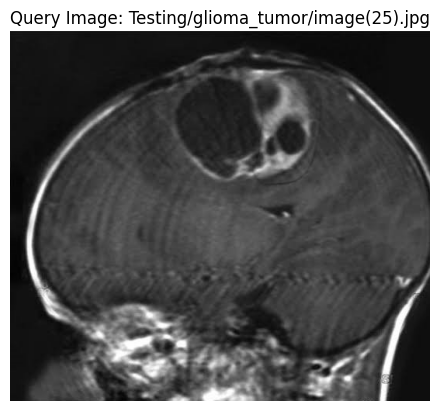

In [21]:
# Get a sample row
random_row_index = 10

# Select the random row and the desired column's value
random_row = testing_embeddings_glioma.iloc[random_row_index]
sample_embedding = [random_row["vectors"]]

# Visualization function
from matplotlib import pyplot as plt


def plotImage(source, label):
    plt.imshow(plt.imread(source))
    plt.axis("off")
    plt.title(label + ": " + source)


plotImage(random_row["image"], "Query Image")

### Search Based on Sample Image

Using the the embeddings we extracted above in `sample_embedding` for this random image, we can search to get the three nearest neighbors to our query image using KDB.AI.

In a real life scenario, the sample images used to search would be ones selected by a doctor.

In [22]:
results = table.search(sample_embedding, n=3)
results

[                                             vectors  \
 0  [0.14853021502494812, 1.6769481897354126, 0.09...   
 1  [0.07081273198127747, 1.56639564037323, 0.0197...   
 2  [0.6748633980751038, 0.6457080245018005, 0.366...   
 
                                    image  __nn_distance  
 0  Training/meningioma_tumor/m3 (73).jpg     845.823669  
 1  Training/meningioma_tumor/m3 (77).jpg     853.264526  
 2  Training/meningioma_tumor/m3 (72).jpg     876.419922  ]

The results returned from `table.search` show the closest matches along with value of nearest neighbour distances `nn_distance`.

Let's visualize these images:

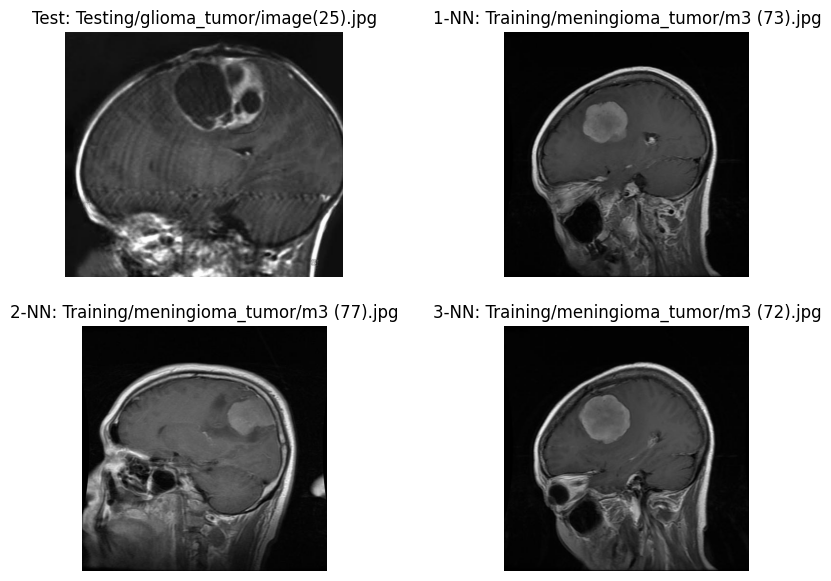

In [23]:
def plotTestResultWith3NN(testFile, neighbours):
    fig = plt.figure(figsize=(10, 7))
    rows = 2
    columns = 2
    fig.add_subplot(rows, columns, 1)
    plotImage(testFile, "Test")

    i = 2
    for key, value in neighbours.items():
        fig.add_subplot(rows, columns, i)
        plotImage(value, str(i - 1) + "-NN")
        i += 1


nn_filenames = results[0]["image"]

plotTestResultWith3NN(random_row["image"], nn_filenames)

We can see that the images returned are similar in nature to the test image and are all the category of Meningioma.

Let's try another sample image and search for similar images.

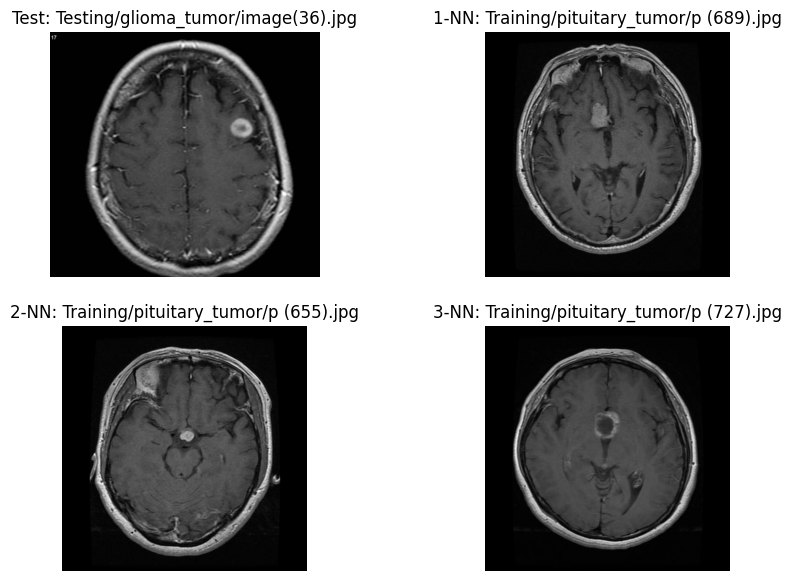

In [24]:
# Get another row
random_row_index = 45

# Select the random row and the desired column's value
random_row = testing_embeddings_glioma.iloc[random_row_index]
sample_embedding = [random_row["vectors"]]

results = table.search(sample_embedding, n=3)


def plotTestResultWith3NN(testFile, neighbours):
    fig = plt.figure(figsize=(10, 7))
    rows = 2
    columns = 2
    fig.add_subplot(rows, columns, 1)
    plotImage(testFile, "Test")

    i = 2
    for key, value in neighbours.items():
        fig.add_subplot(rows, columns, i)
        plotImage(value, str(i - 1) + "-NN")
        i += 1


nn_filenames = results[0]["image"]

plotTestResultWith3NN(random_row["image"], nn_filenames)

We can see with this second test image that we get a set of similar brain scans back that match the second test image closely and are all the category of Pituatary. This kind of result can help a doctor confirm their own assumptions.